# BERT

## 0. Initialize

### 0.1 - Install required libraries

In [1]:
!pip install -q transformers emoji soynlp kaggle pyprnt

### 0.2 - Import libraries

In [2]:
from google.colab import files
import os

import torch
import torch.nn as nn

from transformers import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
#from transformers import ElectraTokenizer, ElectraForSequenceClassification, ElectraConfig
from transformers import get_cosine_schedule_with_warmup

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import random
import time
import datetime
import matplotlib.pyplot as plt

import re
import emoji
from soynlp.normalizer import repeat_normalize
from pyprnt import prnt
from itertools import chain

# 새 섹션

### 0.3 - Initialize Kaggle

In [3]:
if not os.path.exists("/content/kaggle.json"):
    files.upload() # Upload my kaggle.json
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
else:
    pass

### 0.4 - Check CUDA status

In [4]:
# Colab Pro -> P100
! nvidia-smi

Mon May 31 08:58:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 0.5 - Define arguments

In [5]:
class Arguments():
    def __init__(self):
        self.model_name = 'Hate_Classifier_using_kcbert-large'
        #self.model_name = 'Hate_Classifier_using_KcELECTRA-base'

        self.random_seed = 42

        # name of bert from transformers library
        self.pretrained_model = 'beomi/kcbert-base'
        #self.pretrained_model = 'beomi/KcELECTRA-base'
        self.pretrained_tokenizer = None
        if self.pretrained_tokenizer == None:
            self.pretrained_tokenizer = self.pretrained_model

        self.learning_rate = 5e-6
        self.batch_size = 32
        self.max_epoch = 20
        self.early_stop_patience = 4

        self.optimizer = 'AdamW'

        self.data_path = {}
        self.data_path['base']          = '/content/datasets/'
        self.data_path['train']         = self.data_path['base'] + 'train.hate.csv'
        self.data_path['val']           = self.data_path['base'] + 'dev.hate.csv'
        self.data_path['test']          = self.data_path['base'] + 'test.hate.no_label.csv'
        if not os.path.exists(self.data_path['base'] + 'export/'):
            os.mkdir(self.data_path['base'])
            os.mkdir(self.data_path['base'] + 'export/')
        self.data_path['export_test']   = self.data_path['base'] + 'export/export.test.csv'
        self.data_path['export_val']    = self.data_path['base'] + 'export/export.val.csv'
        self.data_path['export_model']  = self.data_path['base'] + 'export/model_checkpoint.pt'

        self.document_column = None
        self.label_column = None

        self.text_max_length = 60
        self.num_class = 3

        self.kaggle_type = 'competitions'
        self.kaggle_name = 'korean-hate-speech-detection'
        self.auto_submit_to_kaggle = True

args = Arguments()

### 0.6 - Download dataset from kaggle

In [6]:
if os.path.exists("/content/kaggle.json") and not os.path.exists(args.data_path['train']):
    if not (args.kaggle_type == 'competitions' or args.kaggle_type == 'datasets'):
        raise NotImplementedError('Invalid kaggle_type')
    print(args.data_path['base'])
    ! kaggle {args.kaggle_type} download -c {args.kaggle_name} -p {args.data_path['base']}
else:
    pass

### 0.7 - Set random seed

In [7]:
random.seed(args.random_seed)
np.random.seed(args.random_seed)
torch.manual_seed(args.random_seed)
torch.cuda.manual_seed_all(args.random_seed)

## 1. Load & Check Dataset

### 1.1 - Read files

In [8]:
def read_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError('"' + path + '"' + ' does not exist')
    if os.path.isdir(path):
        raise IsADirectoryError('"' + path + '"' + ' is a directory ')
    if path.endswith('xlsx'):
        return pd.read_excel(path)
    elif path.endswith('csv'):
        return pd.read_csv(path)
    elif path.endswith('tsv') or path.endswith('txt'):
        return pd.read_csv(path, sep='\t')
    else:
        raise NotImplementedError('Only Excel(xlsx)/Csv/Tsv(txt) are Supported')

dataframes = {}

for key in ['train', 'val', 'test']:
    dataframes[key] = read_data(args.data_path[key])
    #print(dataframes[key].head())

if args.document_column == None:
    args.document_column = dataframes['train'].columns[0]
if args.label_column == None:
    args.label_column = dataframes['train'].columns[1]

## 2. Preprocessing

### 2.1 - Clean text

https://github.com/Beomi/KcBERT#preprocessing

In [9]:
emojis = ''.join(emoji.UNICODE_EMOJI.keys())
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def clean(x):
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

for df in dataframes.values():
    for i in range(0, df.shape[0]):
        df[args.document_column][i] = clean(df[args.document_column][i])

#print(dataframes)

### 2.2 - Encode

encode() = tokenize() + Add [CLS] & [SEP] + convert_tokens_to_ids() + Padding

In [10]:
tokenizer = BertTokenizer.from_pretrained(args.pretrained_tokenizer)
#tokenizer = ElectraTokenizer.from_pretrained(args.pretrained_tokenizer)

for df in dataframes.values():
    df['attention_mask'] = [None] * df.shape[0]

    for i in tqdm(range(0, df.shape[0])):
        df[args.document_column][i] = tokenizer.encode(df[args.document_column][i], 
                                                       padding='max_length', max_length=args.text_max_length,
                                                       add_special_tokens=True, truncation=True)
        
        df['attention_mask'][i] = [float(i > 0) for i in df[args.document_column][i]]

#print(dataframes)

### 2.3 - Labeling

- hate -> 2
- offensive -> 1
- none -> 0

In [11]:
def convert(label):
    if label == "hate":
        return 2
    elif label == "offensive":
        return 1
    elif label == "none":
        return 0
    else:
        raise TypeError("label is not in expected form")

for key in ['train', 'val']:
    for i in tqdm(range(0, dataframes[key].shape[0])):
        dataframes[key][args.label_column][i] = convert(dataframes[key][args.label_column][i])

    #print(dataframes[key][args.label_column])

### 2.4 - Make DataLoader

2.4.1 - convert to pytorch tensor

In [12]:
inputs, labels, masks = {}, {}, {}

for key in ['train', 'val', 'test']:
    inputs[key] = torch.tensor(dataframes[key][args.document_column])
    masks[key]  = torch.tensor(dataframes[key]['attention_mask'])
    
    if key is 'test':
        labels[key] = None
    else:
        labels[key] = torch.tensor(dataframes[key][args.label_column])

#print(inputs['train'])

2.4.2 - make DataLoader

In [13]:
datasets, dataloaders = {}, {}

for key in ['train', 'val', 'test']:
    if key is 'test':
        datasets[key] = TensorDataset(inputs[key], masks[key])
    else:
        datasets[key] = TensorDataset(inputs[key], masks[key], labels[key])
    
    if key is 'train':
        dataloaders[key] = DataLoader(datasets[key], shuffle=True, batch_size = args.batch_size)
    else:
        dataloaders[key] = DataLoader(datasets[key], shuffle=False, batch_size = args.batch_size)

## 3. Define Model

### 3.1 - Define model

In [14]:
class HateClassifier(nn.Module):
    def __init__(self, options):
        super(HateClassifier, self).__init__()

        self.args = options

        self.bert = BertForSequenceClassification.from_pretrained(self.args.pretrained_model,
                                                                  num_labels=self.args.num_class)
        #self.electra = ElectraForSequenceClassification.from_pretrained(self.args.pretrained_model, num_labels=self.args.num_class)
        #self.softmax = nn.Softmax()
    

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        #output = self.electra(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        output = output.logits

        return output

# 새 섹션

### 3.2 - Early stopping

In [15]:
class EarlyStopping():
    def __init__(self, patience=3, path='./checkpoint.pt'):
        self.patience = patience
        self.count = 0
        self.best_acc = 0
        self.early_stop = False
        self.path = path

    def __call__(self, acc, model):
        if acc >= self.best_acc:
            self.best_acc = acc
            self.count = 0

            torch.save(model, self.path)

            self.early_stop = False
        else:
            self.count += 1

            if self.count == self.patience:
                self.early_stop = True
        
        return self.early_stop

### 3.3 - Generate instances

In [16]:
model = HateClassifier(args)
model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=args.learning_rate)

total_steps = len(dataloaders['train']) * args.max_epoch

scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

early_stopping_callback = EarlyStopping(patience=args.early_stop_patience, path=args.data_path['export_model'])

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

## 4. Train

### 4.1 - Train

In [17]:
train_loss = []
train_acc = []

val_loss = []
val_acc = []

print("================================================================")
print("[Start training] - for " + args.model_name)
print("================================================================")

for epoch_i in tqdm(range(args.max_epoch)):

    # ================================
    # Train Sequence
    # ================================
    model.train()
    total_loss = 0
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(dataloaders['train'])):
        model.zero_grad()

        batch = tuple(t.cuda() for t in batch)
        b_input, b_mask, b_label = batch

        predictions = model(input_ids=b_input, attention_mask=b_mask, labels=b_label)
        
        loss = loss_fn(predictions, b_label)
        loss.backward()

        optimizer.step()
        scheduler.step()

        predictions = predictions.argmax(dim=-1)

        total_loss += loss.cpu().detach().numpy().tolist()
        y_true.append(b_label.cpu().numpy())
        y_pred.append(predictions.cpu().numpy())

    y_true = list(chain.from_iterable(y_true)) # 2D -> 1D
    y_pred = list(chain.from_iterable(y_pred))

    train_logs = {
        'train_average_loss':   np.round(total_loss / len(dataloaders['train']), 6),
        'train_acc':            np.round(accuracy_score(y_true, y_pred), 6),
        'train_precision':      np.round(precision_score(y_true, y_pred, average='macro'), 6),
        'train_recall':         np.round(recall_score(y_true=y_true, y_pred=y_pred, average='macro'), 6),
        'train_f1':             np.round(f1_score(y_true=y_true, y_pred=y_pred, average='macro'), 6)
    }
    train_loss.append(train_logs['train_average_loss'])
    train_acc.append(train_logs['train_acc'])

    print("<Epoch " + str(epoch_i+1) + "> - After Train")
    prnt(train_logs)
    
    # ================================
    # Validation Sequence
    # ================================
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []

    for batch in dataloaders['val']:
        batch = tuple(t.cuda() for t in batch)
        b_input, b_mask, b_label = batch

        with torch.no_grad():
            predictions = model(input_ids=b_input,
                           attention_mask=b_mask, labels=b_label)
        
        loss = loss_fn(predictions, b_label)
        predictions = predictions.argmax(dim=-1)

        total_loss += loss.cpu().detach().numpy().tolist()
        y_true.append(b_label.cpu().numpy())
        y_pred.append(predictions.cpu().numpy())

    y_true = list(chain.from_iterable(y_true)) # 2D -> 1D
    y_pred = list(chain.from_iterable(y_pred))
    
    
    val_logs = {
        'val_average_loss':     np.round(total_loss / len(dataloaders['val']), 6),
        'val_acc':              np.round(accuracy_score(y_true=y_true, y_pred=y_pred), 6),
        'val_precision':        np.round(precision_score(y_true=y_true, y_pred=y_pred, average='macro'), 6),
        'val_recall':           np.round(recall_score(y_true=y_true, y_pred=y_pred, average='macro'), 6),
        'val_f1':               np.round(f1_score(y_true=y_true, y_pred=y_pred, average='macro'), 6)
    }
    val_loss.append(val_logs['val_average_loss'])
    val_acc.append(val_logs['val_acc'])

    print("<Epoch " + str(epoch_i+1) + "> - Validation")
    prnt(val_logs)

    if early_stopping_callback(val_logs['val_acc'], model):
        print("[Early Stopping] - at Epoch " + str(epoch_i))
        break

print("================================================================")
print("[Train complete]")
print("================================================================")

[Start training] - for Hate_Classifier_using_kcbert-large



<Epoch 1> - After Train
╭──────────────────┬────────╮
│train_average_loss│0.884103│
│train_acc         │0.567756│
│train_precision   │0.547079│
│train_recall      │0.52918 │
│train_f1          │0.529064│
╰──────────────────┴────────╯
<Epoch 1> - Validation
╭────────────────┬────────╮
│val_average_loss│0.75605 │
│val_acc         │0.658174│
│val_precision   │0.670916│
│val_recall      │0.667697│
│val_f1          │0.660656│
╰────────────────┴────────╯



<Epoch 2> - After Train
╭──────────────────┬────────╮
│train_average_loss│0.719913│
│train_acc         │0.676165│
│train_precision   │0.664251│
│train_recall      │0.661819│
│train_f1          │0.662761│
╰──────────────────┴────────╯
<Epoch 2> - Validation
╭────────────────┬────────╮
│val_average_loss│0.705021│
│val_acc         │0.675159│
│val_precision   │0.687956│
│val_recall      │0.676315│
│val_f1          │0.674882│
╰────────────────┴────────╯



<Epoch 3> - After Train
╭──────────────────┬────────╮
│train_average_loss│0.623839│
│train_acc         │0.727457│
│train_precision   │0.719912│
│train_recall      │0.713171│
│train_f1          │0.716142│
╰──────────────────┴────────╯
<Epoch 3> - Validation
╭────────────────┬────────╮
│val_average_loss│0.745724│
│val_acc         │0.687898│
│val_precision   │0.69625 │
│val_recall      │0.70529 │
│val_f1          │0.687338│
╰────────────────┴────────╯



<Epoch 4> - After Train
╭──────────────────┬────────╮
│train_average_loss│0.525396│
│train_acc         │0.780268│
│train_precision   │0.775662│
│train_recall      │0.769932│
│train_f1          │0.77259 │
╰──────────────────┴────────╯
<Epoch 4> - Validation
╭────────────────┬────────╮
│val_average_loss│0.809148│
│val_acc         │0.649682│
│val_precision   │0.661742│
│val_recall      │0.666445│
│val_f1          │0.648617│
╰────────────────┴────────╯



<Epoch 5> - After Train
╭──────────────────┬────────╮
│train_average_loss│0.417278│
│train_acc         │0.837639│
│train_precision   │0.833485│
│train_recall      │0.829815│
│train_f1          │0.831526│
╰──────────────────┴────────╯
<Epoch 5> - Validation
╭────────────────┬────────╮
│val_average_loss│0.960731│
│val_acc         │0.653928│
│val_precision   │0.676015│
│val_recall      │0.663831│
│val_f1          │0.654924│
╰────────────────┴────────╯



<Epoch 6> - After Train
╭──────────────────┬────────╮
│train_average_loss│0.306246│
│train_acc         │0.887538│
│train_precision   │0.884792│
│train_recall      │0.881075│
│train_f1          │0.882814│
╰──────────────────┴────────╯
<Epoch 6> - Validation
╭────────────────┬────────╮
│val_average_loss│1.145957│
│val_acc         │0.647558│
│val_precision   │0.674396│
│val_recall      │0.655305│
│val_f1          │0.647369│
╰────────────────┴────────╯



<Epoch 7> - After Train
╭──────────────────┬────────╮
│train_average_loss│0.228284│
│train_acc         │0.920213│
│train_precision   │0.918903│
│train_recall      │0.91579 │
│train_f1          │0.917243│
╰──────────────────┴────────╯
<Epoch 7> - Validation
╭────────────────┬────────╮
│val_average_loss│1.108853│
│val_acc         │0.666667│
│val_precision   │0.66918 │
│val_recall      │0.680573│
│val_f1          │0.666307│
╰────────────────┴────────╯
[Early Stopping] - at Epoch 6
[Train complete]


# 새 섹션

### 4.2 - Visualize training result

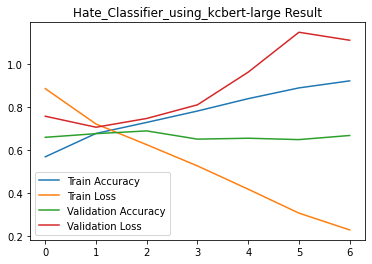

In [18]:
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(train_loss, label = "Train Loss")
plt.plot(val_acc, label = "Validation Accuracy")
plt.plot(val_loss, label = "Validation Loss")

plt.title(args.model_name + " Result" )
plt.legend()
plt.show()

## 5. Evaluate

### 5.1 - Test

In [19]:
print("================================================================")
print("[Start test] - for " + args.model_name)
print("================================================================")

# ================================
# Test Sequence
# ================================
model = torch.load(args.data_path['export_model'])
model.eval()
test_result = []

for batch in tqdm(dataloaders['test']):
    batch = tuple(t.cuda() for t in batch)
    b_input, b_mask = batch

    with torch.no_grad():
        predictions = model(input_ids=b_input,
                            attention_mask=b_mask)
        
    predictions = predictions.argmax(dim=-1)

    test_result.append(predictions.cpu().numpy())

print("================================================================")
print("[Test complete]")
print("================================================================")

test_result = list(chain.from_iterable(test_result)) # 2D -> 1D

[Start test] - for Hate_Classifier_using_kcbert-large



[Test complete]


### 5.2 - Export

In [20]:
dataframes['export'] = pd.read_csv(args.data_path['test'])

dataframes['export'][args.label_column] = [None] * dataframes['export'].shape[0]

for i in tqdm(range(0, len(test_result))):
    dataframes['export'][args.label_column][i] = test_result[i]

dataframes['export'].to_csv(args.data_path['export_test'], sep=',', index=False)
files.download(args.data_path['export_test'])

dataframes['export'].head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,1
1,둘다 넘 좋다~행복하세요,0
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,0
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다...,0


### 5.3 - Submit to Kaggle

# 새 섹션

In [21]:
message = args.model_name + " with best validation acc = " + str(early_stopping_callback.best_acc)
message = '"' + message + '"'

if args.auto_submit_to_kaggle:
    ! kaggle {args.kaggle_type} submit {args.kaggle_name} -f {args.data_path['export_test']} -m {message}
else:
    pass

100% 95.8k/95.8k [00:03<00:00, 31.4kB/s]
Successfully submitted to Korean Hate Speech Detection